### Описание проекта

Многие клиенты пользуются архивными тарифами. Нужно построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.
Построим модель с максимально большим значением accuracy. Доведем долю правильных ответов по крайней мере до 0.75. Проверим accuracy на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков в данных нет, все признаки количественные. Целевой признак is_ultra бинарный. Перед нами задача бинарной классификации. Необходимо изучить признаки:

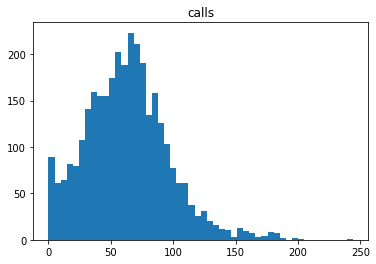

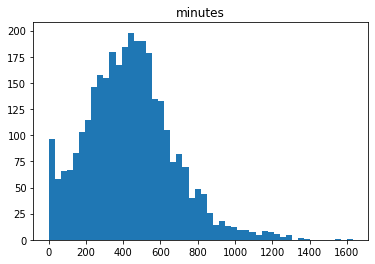

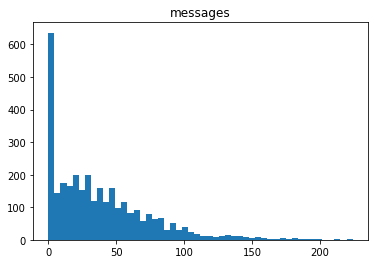

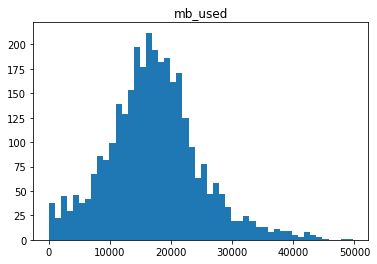

In [5]:
columns = ['calls', 'minutes', 'messages', 'mb_used']
for c in columns:
    df.hist(c, bins=50, grid=False)
    plt.show()

Распределения Пуассона на всех графиках, в messages есть пик около 0.
Проведем анализ факторов, которые войдут в модель. Если есть мультиколлинеарность факторов (когда факторы модели имеют сильную связь друг с другом), то сразу можно один из факторов исключить.

Построим матрицу корреляции для каждых признаков:

In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


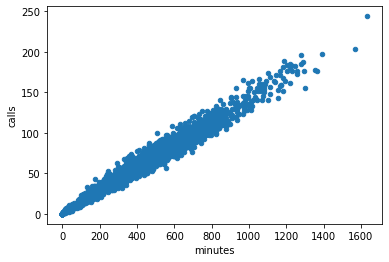

In [7]:
df.plot(kind='scatter', x='minutes', y='calls');

Наиболее высокая корреляция между minutes и calls. Можно отбросить один из признаков для обучения модели.

Разделим исходные данные на обучающую, валидационную и тестовую выборки с пропорцией 3:1:1 :

In [8]:
features = df.drop(['is_ultra', 'calls'], axis=1)
target = df['is_ultra']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [9]:
print(features_train.shape)
print(target_train.shape)
print()
print(features_valid.shape)
print(target_valid.shape)
print()
print(features_test.shape)
print(target_test.shape)

(1928, 3)
(1928,)

(643, 3)
(643,)

(643, 3)
(643,)


Решаем задачу классификации. Тариф "Ультра" - 1, тариф "Смарт" - 0.

Рассмотрим модели решающего дерева, случайного леса и логистической регрессии без подбора гиперпараметров:

In [10]:
def acc_model(model, name):
    model = model(random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = model.score(features_valid, target_valid)
    print(f'{name} :', accuracy)
    
acc_model(DecisionTreeClassifier, 'DecisionTreeClassifier')
acc_model(RandomForestClassifier, 'RandomForestClassifier')
acc_model(LogisticRegression, 'LogisticRegression')

DecisionTreeClassifier : 0.7122861586314152
RandomForestClassifier : 0.7791601866251944
LogisticRegression : 0.7076205287713841


**Наиболее высокий результат у модели RandomForestClassifier - 0.7791601866251944**

Далее настроим гиперпараметры моделей:

### Решающее дерево

In [11]:
best_result = 0
best_depth = 0

for depth in range(1, 10):
    depth_i = depth
    model = DecisionTreeClassifier(max_depth=depth_i, random_state=12345)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    print("Accuracy  модели:", result)
    if result > best_result:
        best_result = result
        best_depth = depth_i

print()
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Глубина дерева: ", best_depth)

Accuracy  модели: 0.7542768273716952
Accuracy  модели: 0.7822706065318819
Accuracy  модели: 0.7853810264385692
Accuracy  модели: 0.7884914463452566
Accuracy  модели: 0.7884914463452566
Accuracy  модели: 0.7744945567651633
Accuracy  модели: 0.7713841368584758
Accuracy  модели: 0.7744945567651633
Accuracy  модели: 0.7791601866251944

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
Глубина дерева:  4


### Случайный лес


In [12]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0

for est in range(10, 51, 10):
    est_i = est
    print(f"Количество деревьев: {est_i}")
    for depth in range (1, 11):
        depth_i = depth
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth_i)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        print(f"Accuracy  модели для глубины {depth_i}:", result)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth_i
            best_est = est_i
    print()

print()
print("Accuracy наилучшей модели на валидационной выборке: ", best_result)
print("Количество деревьев: ", best_est)
print("Глубина дерева: ", best_depth)

Количество деревьев: 10
Accuracy  модели для глубины 1: 0.7480559875583204
Accuracy  модели для глубины 2: 0.7698289269051322
Accuracy  модели для глубины 3: 0.7822706065318819
Accuracy  модели для глубины 4: 0.7838258164852255
Accuracy  модели для глубины 5: 0.7853810264385692
Accuracy  модели для глубины 6: 0.7853810264385692
Accuracy  модели для глубины 7: 0.7916018662519441
Accuracy  модели для глубины 8: 0.7838258164852255
Accuracy  модели для глубины 9: 0.7869362363919129
Accuracy  модели для глубины 10: 0.7869362363919129

Количество деревьев: 20
Accuracy  модели для глубины 1: 0.7465007776049767
Accuracy  модели для глубины 2: 0.7853810264385692
Accuracy  модели для глубины 3: 0.7791601866251944
Accuracy  модели для глубины 4: 0.7853810264385692
Accuracy  модели для глубины 5: 0.7853810264385692
Accuracy  модели для глубины 6: 0.7791601866251944
Accuracy  модели для глубины 7: 0.7916018662519441
Accuracy  модели для глубины 8: 0.7993779160186625
Accuracy  модели для глубины 9: 

### Логистическая регрессия

In [13]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7076205287713841


### Сравнение моделей

- Самое высокое качество у случайного леса при 20 деревьях и глубине дерева 8: **0.7993779160186625**
- На втором месте решающее дерево с параметрами глубины 4: **0.7884914463452566**
- На третьем логистическая регрессия: **0.7076205287713841**

### Проверка модели на тестовой выборке

Для начала обучим модель на выборке train + valid. И проверим на выборке test:

In [14]:
features = pd.concat([features_train, features_valid], axis=0).reset_index(drop=True)
target = pd.concat([target_train, target_valid], axis=0).reset_index(drop=True)

In [15]:
best_model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=8)
best_model.fit(features, target)
accuracy = best_model.score(features_test, target_test)
print('Accuracy лучшей модели:', accuracy)

Accuracy лучшей модели: 0.8087091757387247


In [16]:
best_model_predictions = best_model.predict(features_test)

In [17]:
best_model_predictions = pd.Series(np.squeeze(best_model_predictions))
best_model_predictions.head()

0    0
1    1
2    1
3    0
4    1
dtype: int64

In [18]:
(0.8087091757387247 - 0.7884914463452566) / 0.7884914463452566 * 100

2.564102564102563

Качество модели случайного леса немного увеличилось после обучения на выборке и проверке на тестовой. 

### Вменяемость модели

Сначала необходимо сбросить индексы, чтобы в цикле можно было сравнить значения: 

In [19]:
target_test = target_test.reset_index(drop=True)

Создадим список рандомных ответов с помощью random.randint и преобразуем в объект Series.

In [20]:
# случайная модель
import random
predictions_list = []

for i in range(len(target_test)):
    x = random.randint(0,1)
    predictions_list.append(x)
    
random_model_predictions = pd.Series(predictions_list)

Сравним предсказания случайной модели и реальные ответы тестового признака. Таким же способом сравним предсказания нашей лучшей модели и реальные ответы тестового признака. Если предсказания совпадают с ответами, то +1 к оценке.

Найдем отношение количества предсказаний к реальным ответам:

In [21]:
random_model_score = 0
best_model_score = 0

for i in range(len(target_test)):
    if random_model_predictions[i] == target_test[i]:
        random_model_score += 1
    if best_model_predictions[i] == target_test[i]:
        best_model_score += 1

print('Точность случайной модели', random_model_score / len(target_test))
print('Точность лучшей модели', best_model_score / len(target_test))

Точность случайной модели 0.5256609642301711
Точность лучшей модели 0.8087091757387247


Точность лучшей модели случайного леса с гиперпараметрами (Количество деревьев:  20 и Глубина дерева:  8) по сравнению со случайной  моделью дает ответ, что наша модель случайного леса адекватна для использования. 

### Вывод

Были изучены данные по тарифам и разработаны следующие модели машинного обучения: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression.

Исходные данные поделили на train, valid, test в пропорции 3:1:1.

Лучшая модель: **RandomForestClassifier** с гиперпараметрами (**n_estimators = 20, max_depth=8**)

Accuracy модели на test: **0.8087091757387247**

Модель прошла проверку на вменяемость, так как случайная модель выдала точность **0.5256609642301711**